In [2]:
import cv2
import torch
import os, glob
import numpy as np
import gradio as gr
from PIL import Image
from omegaconf import OmegaConf
from contextlib import nullcontext
from pytorch_lightning import seed_everything
from os.path import join as ospj

from util import *


def predict(cfgs, model, sampler, batch):

    context = nullcontext if cfgs.aae_enabled else torch.no_grad
    
    with context():
        
        batch, batch_uc_1 = prepare_batch(cfgs, batch)

        c, uc_1 = model.conditioner.get_unconditional_conditioning(
            batch,
            batch_uc=batch_uc_1,
            force_uc_zero_embeddings=cfgs.force_uc_zero_embeddings,
        )
        
        x = sampler.get_init_noise(cfgs, model, cond=c, batch=batch, uc=uc_1)
        samples_z = sampler(model, x, cond=c, batch=batch, uc=uc_1, init_step=0,
                            aae_enabled = cfgs.aae_enabled, detailed = cfgs.detailed)

        samples_x = model.decode_first_stage(samples_z)
        samples = torch.clamp((samples_x + 1.0) / 2.0, min=0.0, max=1.0)

        return samples, samples_z


def demo_predict(input_blk, text, num_samples, steps, scale, seed, show_detail):

    global cfgs, global_index

    global_index += 1

    if num_samples > 1: cfgs.noise_iters = 0

    cfgs.batch_size = num_samples
    cfgs.steps = steps
    cfgs.scale[0] = scale
    cfgs.detailed = show_detail
    seed_everything(seed)

    sampler = init_sampling(cfgs)

    image = input_blk["image"]
    mask = input_blk["mask"]
    image = cv2.resize(image, (cfgs.W, cfgs.H))
    mask = cv2.resize(mask, (cfgs.W, cfgs.H))

    mask = (mask == 0).astype(np.int32)

    image = torch.from_numpy(image.transpose(2,0,1)).to(dtype=torch.float32) / 127.5 - 1.0
    mask = torch.from_numpy(mask.transpose(2,0,1)).to(dtype=torch.float32).mean(dim=0, keepdim=True)
    masked = image * mask
    mask = 1 - mask

    seg_mask = torch.cat((torch.ones(len(text)), torch.zeros(cfgs.seq_len-len(text))))

    # additional cond
    txt = f"\"{text}\""
    original_size_as_tuple = torch.tensor((cfgs.H, cfgs.W))
    crop_coords_top_left = torch.tensor((0, 0))
    target_size_as_tuple = torch.tensor((cfgs.H, cfgs.W))

    image = torch.tile(image[None], (num_samples, 1, 1, 1))
    mask = torch.tile(mask[None], (num_samples, 1, 1, 1))
    masked = torch.tile(masked[None], (num_samples, 1, 1, 1))
    seg_mask = torch.tile(seg_mask[None], (num_samples, 1))
    original_size_as_tuple = torch.tile(original_size_as_tuple[None], (num_samples, 1))
    crop_coords_top_left = torch.tile(crop_coords_top_left[None], (num_samples, 1))
    target_size_as_tuple = torch.tile(target_size_as_tuple[None], (num_samples, 1))

    text = [text for i in range(num_samples)]
    txt = [txt for i in range(num_samples)]
    name = [str(global_index) for i in range(num_samples)]

    batch = {
        "image": image,
        "mask": mask,
        "masked": masked,
        "seg_mask": seg_mask,
        "label": text,
        "txt": txt,
        "original_size_as_tuple": original_size_as_tuple,
        "crop_coords_top_left": crop_coords_top_left,
        "target_size_as_tuple": target_size_as_tuple,
        "name": name
    }

    samples, samples_z = predict(cfgs, model, sampler, batch)
    samples = samples.cpu().numpy().transpose(0, 2, 3, 1) * 255
    results = [Image.fromarray(sample.astype(np.uint8)) for sample in samples]

    if cfgs.detailed:
        sections = []
        attn_map = Image.open(f"./temp/attn_map/attn_map_{global_index}.png")
        seg_maps = np.load(f"./temp/seg_map/seg_{global_index}.npy")
        for i, seg_map in enumerate(seg_maps):
            seg_map = cv2.resize(seg_map, (cfgs.W, cfgs.H))
            sections.append((seg_map, text[0][i]))
        seg = (results[0], sections)
    else:
        attn_map = None
        seg = None

    return results, attn_map, seg


if __name__ == "__main__":

    os.makedirs("./temp", exist_ok=True)
    os.makedirs("./temp/attn_map", exist_ok=True)
    os.makedirs("./temp/seg_map", exist_ok=True)

    cfgs = OmegaConf.load("./configs/demo.yaml")

    model = init_model(cfgs)
    global_index = 0

    block = gr.Blocks().queue()
    with block:

        with gr.Row():

            gr.HTML(
                """
                <div style="text-align: center; max-width: 1200px; margin: 20px auto;">
                <h1 style="font-weight: 600; font-size: 2rem; margin: 0.5rem;">
                    UDiffText: A Unified Framework for High-quality Text Synthesis in Arbitrary Images via Character-aware Diffusion Models
                </h1>        
                <ul style="text-align: center; margin: 0.5rem;"> 
                    <li style="display: inline-block; margin:auto;"><a href='https://arxiv.org/abs/2312.04884'><img src='https://img.shields.io/badge/Arxiv-2312.04884-DF826C'></a></li>
                    <li style="display: inline-block; margin:auto;"><a href='https://github.com/ZYM-PKU/UDiffText'><img src='https://img.shields.io/badge/Code-UDiffText-D0F288'></a></li>
                    <li style="display: inline-block; margin:auto;"><a href='https://udifftext.github.io'><img src='https://img.shields.io/badge/Project-UDiffText-8ADAB2'></a></li>
                </ul> 
                <h2 style="text-align: left; font-weight: 450; font-size: 1rem; margin: 0.5rem;">
                    Our proposed UDiffText is capable of synthesizing accurate and harmonious text in either synthetic or real-word images, thus can be applied to tasks like scene text editing (a), arbitrary text generation (b) and accurate T2I generation (c)
                </h2>
                <div align=center><img src="file/demo/teaser.png" alt="UDiffText" width="80%"></div> 
                </div>
                """
            )

        with gr.Row():

            with gr.Column():

                input_blk = gr.Image(source='upload', tool='sketch', type="numpy", label="Input", height=512)
                text = gr.Textbox(label="Text to render:", info="the text you want to render at the masked region")
                run_button = gr.Button(variant="primary")

                with gr.Accordion("Advanced options", open=False):

                    num_samples = gr.Slider(label="Images", info="number of generated images, locked as 1", minimum=1, maximum=1, value=1, step=1)
                    steps = gr.Slider(label="Steps", info ="denoising sampling steps", minimum=1, maximum=200, value=50, step=1)
                    scale = gr.Slider(label="Guidance Scale", info="the scale of classifier-free guidance (CFG)", minimum=0.0, maximum=10.0, value=4.0, step=0.1)
                    seed = gr.Slider(label="Seed", info="random seed for noise initialization", minimum=0, maximum=2147483647, step=1, randomize=True)
                    show_detail = gr.Checkbox(label="Show Detail", info="show the additional visualization results", value=False)

            with gr.Column():

                gallery = gr.Gallery(label="Output", height=512, preview=True)

                with gr.Accordion("Visualization results", open=True):

                    with gr.Tab(label="Attention Maps"):
                        gr.Markdown("### Attention maps for each character (extracted from middle blocks at intermediate sampling step):")
                        attn_map = gr.Image(show_label=False, show_download_button=False)
                    with gr.Tab(label="Segmentation Maps"):
                        gr.Markdown("### Character-level segmentation maps (using upscaled attention maps):")
                        seg_map = gr.AnnotatedImage(height=384, show_label=False)

        # examples
        examples = []
        example_paths = sorted(glob.glob(ospj("./demo/examples", "*")))
        for example_path in example_paths:
            label = example_path.split(os.sep)[-1].split(".")[0].split("_")[0]
            examples.append([example_path, label])

        gr.Markdown("## Examples:")
        gr.Examples(
            examples=examples,
            inputs=[input_blk, text]
        )

        run_button.click(fn=demo_predict, inputs=[input_blk, text, num_samples, steps, scale, seed, show_detail], outputs=[gallery, attn_map, seg_map])

    block.launch(share=True)

Initialized embedder #0: LabelEncoder with 302430208 params. Trainable: False
Initialized embedder #1: SpatialRescaler with 0 params. Trainable: False
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Restored from ./checkpoints/AEs/AE_inpainting_2.safetensors with 0 missing and 0 unexpected keys
Initialized embedder #2: LatentEncoder with 83653863 params. Trainable: False
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Restored from ./checkpoints/AEs/AE_inpainting_2.safetensors with 0

/home/vaishnavi/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vaishnavi/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Restored from ./checkpoints/pretrained/st-step=100000+la-step=100000-v2-002.ckpt with 908 missing and 0 unexpected keys
Missing Keys: ['conditioner.embedders.0.label_embedding.weight', 'conditioner.embedders.0.pos_embedding.pe', 'conditioner.embedders.0.encoder.layers.0.self_attn.in_proj_weight', 'conditioner.embedders.0.encoder.layers.0.self_attn.in_proj_bias', 'conditioner.embedders.0.encoder.layers.0.self_attn.out_proj.weight', 'conditioner.embedders.0.encoder.layers.0.self_attn.out_proj.bias', 'conditioner.embedders.0.encoder.layers.0.linear1.weight', 'conditioner.embedders.0.encoder.layers.0.linear1.bias', 'conditioner.embedders.0.encoder.layers.0.linear2.weight', 'conditioner.embedders.0.encoder.layers.0.linear2.bias', 'conditioner.embedders.0.encoder.layers.0.norm1.weight', 'conditioner.embedders.0.encoder.layers.0.norm1.bias', 'conditioner.embedders.0.encoder.layers.0.norm2.weight', 'conditioner.embedders.0.encoder.layers.0.norm2.bias', 'conditioner.embedders.0.encoder.layers.1

Global seed set to 1294412277


Init local loss: Best -0.09869101643562317 Worst -0.06034751608967781
##############################  Sampling setting  ##############################
Sampler: EulerEDMSampler
Discretization: LegacyDDPMDiscretization
Guider: VanillaCFG


Sampling with EulerEDMSampler for 50 steps: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.57it/s]


Local losses: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Global seed set to 1294412277


Init local loss: Best -0.6470144391059875 Worst -0.6198015809059143
##############################  Sampling setting  ##############################
Sampler: EulerEDMSampler
Discretization: LegacyDDPMDiscretization
Guider: VanillaCFG


Sampling with EulerEDMSampler for 50 steps: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.53it/s]


Local losses: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Global seed set to 1294412277


Init local loss: Best -0.2630099356174469 Worst -0.14134950935840607
##############################  Sampling setting  ##############################
Sampler: EulerEDMSampler
Discretization: LegacyDDPMDiscretization
Guider: VanillaCFG


Sampling with EulerEDMSampler for 50 steps: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.52it/s]


Local losses: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Global seed set to 1294412277


Init local loss: Best -0.3681034743785858 Worst -0.06949955224990845
##############################  Sampling setting  ##############################
Sampler: EulerEDMSampler
Discretization: LegacyDDPMDiscretization
Guider: VanillaCFG


Sampling with EulerEDMSampler for 50 steps: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.49it/s]


Local losses: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Global seed set to 1294412277


Init local loss: Best -0.3699600398540497 Worst -0.255234956741333
##############################  Sampling setting  ##############################
Sampler: EulerEDMSampler
Discretization: LegacyDDPMDiscretization
Guider: VanillaCFG


Sampling with EulerEDMSampler for 50 steps: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.56it/s]


Local losses: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Global seed set to 1294412277


Init local loss: Best -0.5256773829460144 Worst -0.4565891623497009
##############################  Sampling setting  ##############################
Sampler: EulerEDMSampler
Discretization: LegacyDDPMDiscretization
Guider: VanillaCFG


Sampling with EulerEDMSampler for 50 steps: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.53it/s]


Local losses: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
def predict(cfgs, model, batch):
    context = nullcontext() if cfgs.aae_enabled else torch.no_grad()
    with context:
        # Assuming prepare_batch is a function that processes the batch as needed
        batch = prepare_batch(cfgs, batch)
        
        # Model prediction logic
        c, uc_1 = model.conditioner.get_unconditional_conditioning(
            batch,
            force_uc_zero_embeddings=cfgs.force_uc_zero_embeddings
        )
        
        x = model.get_init_noise(c, uc_1)
        samples_z = model.sample(x, c, uc_1, init_step=0, aae_enabled=cfgs.aae_enabled, detailed=cfgs.detailed)
        samples_x = model.decode_first_stage(samples_z)
        samples = torch.clamp((samples_x + 1.0) / 2.0, min=0.0, max=1.0)
        
        return samples

In [ ]:
import matplotlib.pyplot as plt

def process_and_predict(image_path, mask_path, text):
    # Load image and mask
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Unable to load image at {image_path}")

    mask = cv2.imread(mask_path, 0)  # Load mask as grayscale
    if mask is None:
        raise FileNotFoundError(f"Unable to load mask at {mask_path}")

    # Resize and process image and mask to match model expectations
    image = cv2.resize(image, (cfgs.W, cfgs.H))
    mask = cv2.resize(mask, (cfgs.W, cfgs.H))
    mask = (mask > 128).astype(np.uint8)  # Threshold mask to binary

    # Convert to PyTorch tensors
    image_tensor = torch.from_numpy(image.transpose(2, 0, 1)).float() / 127.5 - 1
    mask_tensor = torch.from_numpy(mask).float().unsqueeze(0)  # Add channel dimension

    # Prepare batch
    batch = {
        "image": image_tensor.unsqueeze(0),  # Add batch dimension
        "mask": mask_tensor.unsqueeze(0),  # Add batch dimension
        "text": text,  # Assuming 'text' is the human-readable text
        "txt": [text]  # Assuming 'txt' is required as a list of texts
    }

    # Predict using the model
    output = predict(cfgs, model, batch)
    output_image = output[0].squeeze().numpy().transpose(1, 2, 0) * 255

    # Display the image using matplotlib
    plt.imshow(output_image.astype(np.uint8))
    plt.title("Generated Image")
    plt.show()


In [ ]:
if __name__ == "__main__":
    cfgs = OmegaConf.load("./configs/demo.yaml")
    model = init_model(cfgs)
    process_and_predict('Triplet/tower.png', 'Triplet/masked.png', "Tower")

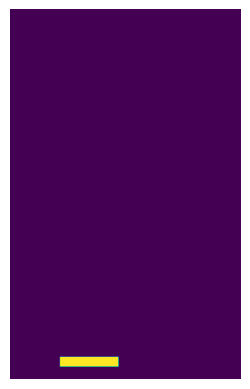

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

# Load your image
image = Image.open('Triplet/masked.png')

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


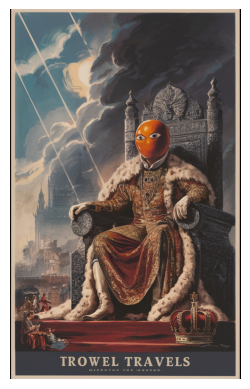

In [4]:
# Load your image
image = Image.open('Triplet/tower.png')

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from util import *



In [ ]:
def load_and_process_image(image_path, mask_path, target_size):
    # Load images
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, 0)  # Load as grayscale

    # Resize images
    image = cv2.resize(image, target_size)
    mask = cv2.resize(mask, target_size)

    # Prepare mask (assuming mask's regions of interest are white)
    mask = (mask > 0).astype(np.float32)

    # Convert images to PyTorch tensors
    image_tensor = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
    mask_tensor = torch.from_numpy(mask).float().unsqueeze(0)  # Add channel dimension

    return image_tensor, mask_tensor


In [ ]:
def run_model(image_path, mask_path, cfg_path):
    # Load configuration
    cfgs = OmegaConf.load(cfg_path)
    model = init_model(cfgs)
    sampler = init_sampling(cfgs)

    # Load and process image and mask
    image, mask = load_and_process_image(image_path, mask_path, (cfgs.W, cfgs.H))

    # Prepare batch (single example for simplicity)
    batch = {
        "image": image.unsqueeze(0),  # Add batch dimension
        "mask": mask.unsqueeze(0),  # Add batch dimension
    }

    # Predict using the model
    with torch.no_grad():  # Ensure no gradients are computed
        samples, _ = predict(cfgs, model, sampler, batch)

    # Convert tensor to image for display
    output_image = samples[0].permute(1, 2, 0).cpu().numpy()  # Adjust dimensions for plotting
    plt.imshow(output_image)
    plt.title("Model Output")
    plt.axis('off')
    plt.show()


In [ ]:
if __name__ == "__main__":
    image_path = 'Triplet/tower.png'  # Path to the input image
    mask_path = 'Triplet/masked.png'  # Path to the mask image
    cfg_path = './configs/demo.yaml'  # Configuration file path

    run_model(image_path, mask_path, cfg_path)


In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

def init_model(cfgs):
    # Dummy model initialization for demonstration
    # Replace this with actual model initialization logic
    return torch.nn.Sequential(
        torch.nn.Conv2d(3, 16, kernel_size=3, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(16, 3, kernel_size=3, padding=1),
        torch.nn.Sigmoid()
    )

def init_sampling(cfgs):
    # Dummy sampler initialization for demonstration
    # Replace this with actual sampling logic
    class Sampler:
        def get_init_noise(self, cfgs, model, cond, batch, uc):
            return torch.randn_like(batch['image'])  # Simulated noise
        def __call__(self, model, x, cond, batch, uc, init_step, aae_enabled, detailed):
            return model(x)  # Dummy pass-through for demonstration
    return Sampler()

def predict(cfgs, model, sampler, batch):
    # Dummy predict function
    # Replace with actual model prediction logic
    x = sampler.get_init_noise(cfgs, model, None, batch, None)
    samples_z = sampler(model, x, None, batch, None, 0, cfgs.aae_enabled, cfgs.detailed)
    samples_x = model(samples_z)
    samples = torch.clamp((samples_x + 1.0) / 2.0, min=0.0, max=1.0)
    return samples, samples_z

def load_and_process_image(image_path, mask_path, target_size):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, 0)
    image = cv2.resize(image, target_size)
    mask = cv2.resize(mask, target_size)
    mask = (mask > 0).astype(np.float32)
    image_tensor = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
    mask_tensor = torch.from_numpy(mask).float().unsqueeze(0)
    return image_tensor, mask_tensor

def run_model(image_path, mask_path, cfg_path):
    cfgs = OmegaConf.load(cfg_path)
    model = init_model(cfgs)
    sampler = init_sampling(cfgs)

    image, mask = load_and_process_image(image_path, mask_path, (cfgs.W, cfgs.H))

    # Debug: Display input images and masks
    plt.imshow(image.permute(1, 2, 0))
    plt.title("Input Image")
    plt.show()
    plt.imshow(mask[0], cmap='gray')
    plt.title("Input Mask")
    plt.show()

    batch = {"image": image.unsqueeze(0), "mask": mask.unsqueeze(0)}
    with torch.no_grad():
        samples, _ = predict(cfgs, model, sampler, batch)
        print("Output stats:", samples.min().item(), samples.max().item(), samples.mean().item())  # Debug output statistics

    output_image = samples[0].permute(1, 2, 0).cpu().numpy()
    plt.imshow(output_image)
    plt.title("Model Output")
    plt.axis('off')
    plt.show()


if __name__ == "__main__":
    image_path = 'Triplet/tower.png'  # Path to the input image
    mask_path = 'Triplet/masked.png'  # Path to the mask image
    cfg_path = './configs/demo.yaml'  # Configuration file path
    run_model(image_path, mask_path, cfg_path)

In [ ]:
import cv2
import torch
import os, glob
import numpy as np
import gradio as gr
from PIL import Image
from omegaconf import OmegaConf
from contextlib import nullcontext
from pytorch_lightning import seed_everything
from os.path import join as ospj

from util import *


def predict(cfgs, model, sampler, batch):

    context = nullcontext if cfgs.aae_enabled else torch.no_grad
    
    with context():
        
        batch, batch_uc_1 = prepare_batch(cfgs, batch)

        c, uc_1 = model.conditioner.get_unconditional_conditioning(
            batch,
            batch_uc=batch_uc_1,
            force_uc_zero_embeddings=cfgs.force_uc_zero_embeddings,
        )
        
        x = sampler.get_init_noise(cfgs, model, cond=c, batch=batch, uc=uc_1)
        samples_z = sampler(model, x, cond=c, batch=batch, uc=uc_1, init_step=0,
                            aae_enabled = cfgs.aae_enabled, detailed = cfgs.detailed)

        samples_x = model.decode_first_stage(samples_z)
        samples = torch.clamp((samples_x + 1.0) / 2.0, min=0.0, max=1.0)

        return samples, samples_z


def demo_predict(input_blk, text, num_samples, steps, scale, seed, show_detail):

    global cfgs, global_index

    global_index += 1

    if num_samples > 1: cfgs.noise_iters = 0

    cfgs.batch_size = num_samples
    cfgs.steps = steps
    cfgs.scale[0] = scale
    cfgs.detailed = show_detail
    seed_everything(seed)

    sampler = init_sampling(cfgs)

    image = input_blk["image"]
    mask = input_blk["mask"]
    image = cv2.resize(image, (cfgs.W, cfgs.H))
    mask = cv2.resize(mask, (cfgs.W, cfgs.H))

    mask = (mask == 0).astype(np.int32)

    image = torch.from_numpy(image.transpose(2,0,1)).to(dtype=torch.float32) / 127.5 - 1.0
    mask = torch.from_numpy(mask.transpose(2,0,1)).to(dtype=torch.float32).mean(dim=0, keepdim=True)
    masked = image * mask
    mask = 1 - mask

    seg_mask = torch.cat((torch.ones(len(text)), torch.zeros(cfgs.seq_len-len(text))))

    # additional cond
    txt = f"\"{text}\""
    original_size_as_tuple = torch.tensor((cfgs.H, cfgs.W))
    crop_coords_top_left = torch.tensor((0, 0))
    target_size_as_tuple = torch.tensor((cfgs.H, cfgs.W))

    image = torch.tile(image[None], (num_samples, 1, 1, 1))
    mask = torch.tile(mask[None], (num_samples, 1, 1, 1))
    masked = torch.tile(masked[None], (num_samples, 1, 1, 1))
    seg_mask = torch.tile(seg_mask[None], (num_samples, 1))
    original_size_as_tuple = torch.tile(original_size_as_tuple[None], (num_samples, 1))
    crop_coords_top_left = torch.tile(crop_coords_top_left[None], (num_samples, 1))
    target_size_as_tuple = torch.tile(target_size_as_tuple[None], (num_samples, 1))

    text = [text for i in range(num_samples)]
    txt = [txt for i in range(num_samples)]
    name = [str(global_index) for i in range(num_samples)]

    batch = {
        "image": image,
        "mask": mask,
        "masked": masked,
        "seg_mask": seg_mask,
        "label": text,
        "txt": txt,
        "original_size_as_tuple": original_size_as_tuple,
        "crop_coords_top_left": crop_coords_top_left,
        "target_size_as_tuple": target_size_as_tuple,
        "name": name
    }

    samples, samples_z = predict(cfgs, model, sampler, batch)
    samples = samples.cpu().numpy().transpose(0, 2, 3, 1) * 255
    results = [Image.fromarray(sample.astype(np.uint8)) for sample in samples]

    if cfgs.detailed:
        sections = []
        attn_map = Image.open(f"./temp/attn_map/attn_map_{global_index}.png")
        seg_maps = np.load(f"./temp/seg_map/seg_{global_index}.npy")
        for i, seg_map in enumerate(seg_maps):
            seg_map = cv2.resize(seg_map, (cfgs.W, cfgs.H))
            sections.append((seg_map, text[0][i]))
        seg = (results[0], sections)
    else:
        attn_map = None
        seg = None

    return results, attn_map, seg
   

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# input_image_path = 'Triplet/tower.png'  # Ensure this path is correct
# input_mask_path =  'Triplet/masked.png'    # Ensure this path is correct
# Ensure global_index is initialized
global_index = 0


import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

def manual_input_interface():
    global global_index

    input_image_path = 'Triplet/tower.png'  # Ensure this path is correct
    input_mask_path =  'Triplet/masked.png'    # Ensure this path is correct

    if not os.path.exists(input_image_path) or not os.path.exists(input_mask_path):
        print(f"Error: Check if the files exist and paths are correct.")
        print(f"Attempted image path: {input_image_path}")
        print(f"Attempted mask path: {input_mask_path}")
        return

    input_image = cv2.imread(input_image_path)
    input_mask = cv2.imread(input_mask_path, cv2.IMREAD_GRAYSCALE)

    if input_image is None or input_mask is None:
        print("Failed to load image or mask.")
        return

    # Check types before resizing
    if not isinstance(input_image, np.ndarray) or not isinstance(input_mask, np.ndarray):
        print("Type error: input_image or input_mask is not a numpy array.")
        return

    input_text = "Tower"
    num_samples = 1
    steps = 50
    scale = 4.0
    seed = 123456
    show_detail = True

    # Ensure mask is binary
    input_mask = (input_mask > 128).astype(np.uint8)

    # Resize the image and mask to your model's expected input size
    H, W = 512,512
    input_image = cv2.resize(input_image, (W, H))
    input_mask = cv2.resize(input_mask, (W, H), interpolation=cv2.INTER_NEAREST)

    # Convert to torch tensors after all image processing
    input_image = torch.from_numpy(input_image.transpose(2, 0, 1)).float() / 255.0
    input_mask = torch.from_numpy(input_mask).float().unsqueeze(0)  # Ensure single channel for the mask

    input_blk = {
        "image": input_image,
        "mask": input_mask
    }

    try:
        results, attn_map, seg = demo_predict(input_blk, input_text, num_samples, steps, scale, seed, show_detail)
        # Visualization or further processing goes here...
    except Exception as e:
        print(f"An error occurred during prediction: {str(e)}")

manual_input_interface()




In [ ]:
if __name__ == "__main__":
    os.makedirs("./temp", exist_ok=True)
    os.makedirs("./temp/attn_map", exist_ok=True)
    os.makedirs("./temp/seg_map", exist_ok=True)

    cfgs = OmegaConf.load("./configs/demo.yaml")
    model = init_model(cfgs)
    global_index = 0

    # Here we would replace Gradio block with a manual input function
    manual_input_interface()

Initialized embedder #0: LabelEncoder with 302430208 params. Trainable: False
Initialized embedder #1: SpatialRescaler with 0 params. Trainable: False
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Restored from ./checkpoints/AEs/AE_inpainting_2.safetensors with 0 missing and 0 unexpected keys
Initialized embedder #2: LatentEncoder with 83653863 params. Trainable: False
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Restored from ./checkpoints/AEs/AE_inpainting_2.safetensors with 0

Global seed set to 42


Init local loss: Best -0.5351752638816833 Worst -0.05983133986592293
##############################  Sampling setting  ##############################
Sampler: EulerEDMSampler
Discretization: LegacyDDPMDiscretization
Guider: VanillaCFG


Sampling with EulerEDMSampler for 50 steps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.19it/s]


Local losses: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


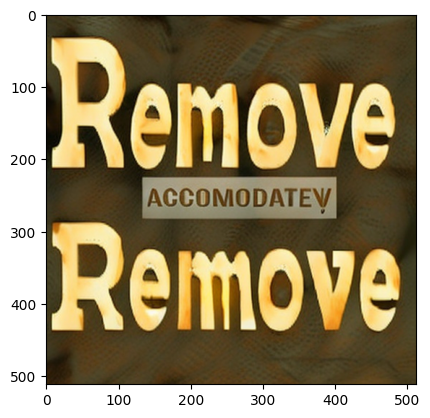

In [29]:
import cv2
import torch
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from contextlib import nullcontext
from pytorch_lightning import seed_everything
from os.path import join as ospj

from util import *

# Assuming `util.py` contains all necessary utility functions and model definitions.

# Configuration and Model Initialization
cfgs = OmegaConf.load("./configs/demo.yaml")
model = init_model(cfgs)
sampler = init_sampling(cfgs)
global_index = 0

def predict(cfgs, model, sampler, batch):
    context = nullcontext() if cfgs.aae_enabled else torch.no_grad()
    with context:
        batch, batch_uc_1 = prepare_batch(cfgs, batch)
        c, uc_1 = model.conditioner.get_unconditional_conditioning(
            batch,
            batch_uc=batch_uc_1,
            force_uc_zero_embeddings=cfgs.force_uc_zero_embeddings,
        )
        
        x = sampler.get_init_noise(cfgs, model, cond=c, batch=batch, uc=uc_1)
        samples_z = sampler(model, x, cond=c, batch=batch, uc=uc_1, init_step=0,
                            aae_enabled=cfgs.aae_enabled, detailed=cfgs.detailed)
        samples_x = model.decode_first_stage(samples_z)
        samples = torch.clamp((samples_x + 1.0) / 2.0, min=0.0, max=1.0)
        return samples, samples_z

def demo_predict(image_path, mask_path, text, num_samples, steps, scale, seed, show_detail):
    global cfgs, global_index

    global_index += 1

    if num_samples > 1:
        cfgs.noise_iters = 0

    cfgs.batch_size = num_samples
    cfgs.steps = steps
    cfgs.scale[0] = scale
    cfgs.detailed = show_detail
    seed_everything(seed)

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, 0)
    image = cv2.resize(image, (cfgs.W, cfgs.H))
    mask = cv2.resize(mask, (cfgs.W, cfgs.H))

    mask = (mask > 128).astype(np.float32)  # Assuming thresholding to create binary mask

    image = torch.from_numpy(image.transpose(2, 0, 1)).to(dtype=torch.float32) / 127.5 - 1.0
    mask = torch.from_numpy(mask).unsqueeze(0).to(dtype=torch.float32)  # Add channel dimension without transposing
    masked = image * mask
    mask = 1 - mask

    seg_mask = torch.cat((torch.ones(len(text)), torch.zeros(cfgs.seq_len - len(text))))

    txt = f"\"{text}\""
    original_size_as_tuple = torch.tensor((cfgs.H, cfgs.W))
    crop_coords_top_left = torch.tensor((0, 0))
    target_size_as_tuple = torch.tensor((cfgs.H, cfgs.W))

    image = torch.tile(image[None], (num_samples, 1, 1, 1))
    mask = torch.tile(mask[None], (num_samples, 1, 1, 1))
    masked = torch.tile(masked[None], (num_samples, 1, 1, 1))
    seg_mask = torch.tile(seg_mask[None], (num_samples, 1))
    original_size_as_tuple = torch.tile(original_size_as_tuple[None], (num_samples, 1))
    crop_coords_top_left = torch.tile(crop_coords_top_left[None], (num_samples, 1))
    target_size_as_tuple = torch.tile(target_size_as_tuple[None], (num_samples, 1))

    text = [text for i in range(num_samples)]
    txt = [txt for i in range(num_samples)]
    name = [str(global_index) for i in range(num_samples)]

    batch = {
        "image": image,
        "mask": mask,
        "masked": masked,
        "seg_mask": seg_mask,
        "label": text,
        "txt": txt,
        "original_size_as_tuple": original_size_as_tuple,
        "crop_coords_top_left": crop_coords_top_left,
        "target_size_as_tuple": target_size_as_tuple,
        "name": name
    }

    samples, samples_z = predict(cfgs, model, sampler, batch)
    samples = samples.cpu().numpy().transpose(0, 2, 3, 1) * 255
    results = [Image.fromarray(sample.astype(np.uint8)) for sample in samples]

    if cfgs.detailed:
        sections = []
        attn_map = Image.open(f"./temp/attn_map/attn_map_{global_index}.png")
        seg_maps = np.load(f"./temp/seg_map/seg_{global_index}.npy")
        for i, seg_map in enumerate(seg_maps):
            seg_map = cv2.resize(seg_map, (cfgs.W, cfgs.H))
            sections.append((seg_map, text[0][i]))
        seg = (results[0], sections)
    else:
        attn_map = None
        seg = None

    return results, attn_map, seg


# # Example usage in Jupyter Notebook
# image_path = 'Triplet/tower.png'  # Ensure this path is correct
# mask_path =  'Triplet/masked.png'    # Ensure this path is correct
# text = "Tower"

image_path = 'new/img3.jpg'  # Ensure this path is correct
mask_path =  'new/img3_masked.jpg'    # Ensure this path is correct
text = "Remove"
num_samples = 1
steps = 50
scale = 4.0
seed = 42
show_detail = True

results, attn_map, seg = demo_predict(image_path, mask_path, text, num_samples, steps, scale, seed, show_detail)
for result in results:
    plt.imshow(result)
    plt.show()


In [1]:
def display_images(original_image, mask, masked_image, results):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))  # Adjust subplot dimensions as needed
    
    # Original Image
    ax[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    
    # Mask
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Mask")
    ax[1].axis('off')
    
    # Masked Image
    ax[2].imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    ax[2].set_title("Masked Image")
    ax[2].axis('off')
    
    # Result
    ax[3].imshow(results)
    ax[3].set_title("Result")
    ax[3].axis('off')
    
    plt.show()

# Load and preprocess the image and mask
def load_image_and_mask(image_path, mask_path, cfgs):
    original_image = cv2.imread(image_path)
    mask_image = cv2.imread(mask_path, 0)
    resized_image = cv2.resize(original_image, (cfgs.W, cfgs.H))
    resized_mask = cv2.resize(mask_image, (cfgs.W, cfgs.H))
    binary_mask = (resized_mask > 128).astype(np.float32)  # Creating a binary mask

    mask = torch.from_numpy(binary_mask).unsqueeze(0).to(dtype=torch.float32)  # Add channel dimension
    image = torch.from_numpy(resized_image.transpose(2, 0, 1)).to(dtype=torch.float32) / 127.5 - 1.0  # Normalize and permute axes
    masked_image = (image * mask).numpy().transpose(1, 2, 0) * 127.5 + 127.5  # Un-normalize for display
    masked_image = np.clip(masked_image, 0, 255).astype(np.uint8)  # Clip values to display correctly
    
    return original_image, binary_mask, masked_image, image, mask

# Main execution for demo_predict
results, attn_map, seg = demo_predict(image_path, mask_path, text, num_samples, steps, scale, seed, show_detail)

# Load images and prepare for display
original_image, mask, masked_image, _, _ = load_image_and_mask(image_path, mask_path, cfgs)

# Displaying results alongside the original and masked images
for result in results:
    display_images(original_image, mask, masked_image, result)


NameError: name 'demo_predict' is not defined

In [6]:
import cv2
import torch
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from contextlib import nullcontext
from pytorch_lightning import seed_everything
from os.path import join as ospj

from util import *

# Assuming `util.py` contains all necessary utility functions and model definitions.

# Configuration and Model Initialization
cfgs = OmegaConf.load("./configs/demo.yaml")
model = init_model(cfgs)
sampler = init_sampling(cfgs)
global_index = 0

def predict(cfgs, model, sampler, batch):
    context = nullcontext() if cfgs.aae_enabled else torch.no_grad()
    with context:
        batch, batch_uc_1 = prepare_batch(cfgs, batch)
        c, uc_1 = model.conditioner.get_unconditional_conditioning(
            batch,
            batch_uc=batch_uc_1,
            force_uc_zero_embeddings=cfgs.force_uc_zero_embeddings,
        )
        
        x = sampler.get_init_noise(cfgs, model, cond=c, batch=batch, uc=uc_1)
        samples_z = sampler(model, x, cond=c, batch=batch, uc=uc_1, init_step=0,
                            aae_enabled=cfgs.aae_enabled, detailed=cfgs.detailed)
        samples_x = model.decode_first_stage(samples_z)
        samples = torch.clamp((samples_x + 1.0) / 2.0, min=0.0, max=1.0)
        return samples, samples_z

def demo_predict(image_path, mask_path, text, num_samples, steps, scale, seed, show_detail):
    global cfgs, global_index

    global_index += 1

    if num_samples > 1:
        cfgs.noise_iters = 0

    cfgs.batch_size = num_samples
    cfgs.steps = steps
    cfgs.scale[0] = scale
    cfgs.detailed = show_detail
    seed_everything(seed)

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, 0)
    image = cv2.resize(image, (cfgs.W, cfgs.H))
    mask = cv2.resize(mask, (cfgs.W, cfgs.H))

    mask = (mask > 128).astype(np.float32)  # Assuming thresholding to create binary mask

    image = torch.from_numpy(image.transpose(2, 0, 1)).to(dtype=torch.float32) / 127.5 - 1.0
    mask = torch.from_numpy(mask).unsqueeze(0).to(dtype=torch.float32)  # Add channel dimension without transposing
    masked = image * mask
    mask = 1 - mask

    seg_mask = torch.cat((torch.ones(len(text)), torch.zeros(cfgs.seq_len - len(text))))

    txt = f"\"{text}\""
    original_size_as_tuple = torch.tensor((cfgs.H, cfgs.W))
    crop_coords_top_left = torch.tensor((0, 0))
    target_size_as_tuple = torch.tensor((cfgs.H, cfgs.W))

    image = torch.tile(image[None], (num_samples, 1, 1, 1))
    mask = torch.tile(mask[None], (num_samples, 1, 1, 1))
    masked = torch.tile(masked[None], (num_samples, 1, 1, 1))
    seg_mask = torch.tile(seg_mask[None], (num_samples, 1))
    original_size_as_tuple = torch.tile(original_size_as_tuple[None], (num_samples, 1))
    crop_coords_top_left = torch.tile(crop_coords_top_left[None], (num_samples, 1))
    target_size_as_tuple = torch.tile(target_size_as_tuple[None], (num_samples, 1))

    text = [text for i in range(num_samples)]
    txt = [txt for i in range(num_samples)]
    name = [str(global_index) for i in range(num_samples)]

    batch = {
        "image": image,
        "mask": mask,
        "masked": masked,
        "seg_mask": seg_mask,
        "label": text,
        "txt": txt,
        "original_size_as_tuple": original_size_as_tuple,
        "crop_coords_top_left": crop_coords_top_left,
        "target_size_as_tuple": target_size_as_tuple,
        "name": name
    }

    samples, samples_z = predict(cfgs, model, sampler, batch)
    samples = samples.cpu().numpy().transpose(0, 2, 3, 1) * 255
    results = [Image.fromarray(sample.astype(np.uint8)) for sample in samples]

    if cfgs.detailed:
        sections = []
        attn_map = Image.open(f"./temp/attn_map/attn_map_{global_index}.png")
        seg_maps = np.load(f"./temp/seg_map/seg_{global_index}.npy")
        for i, seg_map in enumerate(seg_maps):
            seg_map = cv2.resize(seg_map, (cfgs.W, cfgs.H))
            sections.append((seg_map, text[0][i]))
        seg = (results[0], sections)
    else:
        attn_map = None
        seg = None

    return results, attn_map, seg


# Example usage in Jupyter Notebook
image_path = 'Triplet/tower.png'  # Ensure this path is correct
mask_path =  'Triplet/masked.png'    # Ensure this path is correct
text = "Tower"
num_samples = 1
steps = 50
scale = 4.0
seed = 42
show_detail = True

results, attn_map, seg = demo_predict(image_path, mask_path, text, num_samples, steps, scale, seed, show_detail)
for result in results:
    plt.imshow(result)
    plt.show()


In [8]:
import cv2
import torch
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from contextlib import nullcontext
from pytorch_lightning import seed_everything
from os.path import join as ospj

from util import *

# Assuming `util.py` contains all necessary utility functions and model definitions.

# Configuration and Model Initialization
cfgs = OmegaConf.load("./configs/demo.yaml")
model = init_model(cfgs)
sampler = init_sampling(cfgs)
global_index = 0

def predict(cfgs, model, sampler, batch):
    context = nullcontext() if cfgs.aae_enabled else torch.no_grad()
    with context:
        batch, batch_uc_1 = prepare_batch(cfgs, batch)
        c, uc_1 = model.conditioner.get_unconditional_conditioning(
            batch,
            batch_uc=batch_uc_1,
            force_uc_zero_embeddings=cfgs.force_uc_zero_embeddings,
        )
        
        x = sampler.get_init_noise(cfgs, model, cond=c, batch=batch, uc=uc_1)
        samples_z = sampler(model, x, cond=c, batch=batch, uc=uc_1, init_step=0,
                            aae_enabled=cfgs.aae_enabled, detailed=cfgs.detailed)
        samples_x = model.decode_first_stage(samples_z)
        samples = torch.clamp((samples_x + 1.0) / 2.0, min=0.0, max=1.0)
        return samples, samples_z

def demo_predict(image_path, mask_path, text, num_samples, steps, scale, seed, show_detail):
    global cfgs, global_index

    global_index += 1

    if num_samples > 1:
        cfgs.noise_iters = 0

    cfgs.batch_size = num_samples
    cfgs.steps = steps
    cfgs.scale[0] = scale
    cfgs.detailed = show_detail
    seed_everything(seed)

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, 0)
    image = cv2.resize(image, (cfgs.W, cfgs.H))
    mask = cv2.resize(mask, (cfgs.W, cfgs.H))
    mask = (mask == 0).astype(np.int32)

    image = torch.from_numpy(image.transpose(2, 0, 1)).to(dtype=torch.float32) / 127.5 - 1.0
    mask = torch.from_numpy(mask.transpose(2, 0, 1)).to(dtype=torch.float32).mean(dim=0, keepdim=True)
    masked = image * mask
    mask = 1 - mask

    seg_mask = torch.cat((torch.ones(len(text)), torch.zeros(cfgs.seq_len - len(text))))

    txt = f"\"{text}\""
    original_size_as_tuple = torch.tensor((cfgs.H, cfgs.W))
    crop_coords_top_left = torch.tensor((0, 0))
    target_size_as_tuple = torch.tensor((cfgs.H, cfgs.W))

    image = torch.tile(image[None], (num_samples, 1, 1, 1))
    mask = torch.tile(mask[None], (num_samples, 1, 1, 1))
    masked = torch.tile(masked[None], (num_samples, 1, 1, 1))
    seg_mask = torch.tile(seg_mask[None], (num_samples, 1))
    original_size_as_tuple = torch.tile(original_size_as_tuple[None], (num_samples, 1))
    crop_coords_top_left = torch.tile(crop_coords_top_left[None], (num_samples, 1))
    target_size_as_tuple = torch.tile(target_size_as_tuple[None], (num_samples, 1))

    text = [text for i in range(num_samples)]
    txt = [txt for i in range(num_samples)]
    name = [str(global_index) for i in range(num_samples)]

    batch = {
        "image": image,
        "mask": mask,
        "masked": masked,
        "seg_mask": seg_mask,
        "label": text,
        "txt": txt,
        "original_size_as_tuple": original_size_as_tuple,
        "crop_coords_top_left": crop_coords_top_left,
        "target_size_as_tuple": target_size_as_tuple,
        "name": name
    }

    samples, samples_z = predict(cfgs, model, sampler, batch)
    samples = samples.cpu().numpy().transpose(0, 2, 3, 1) * 255
    results = [Image.fromarray(sample.astype(np.uint8)) for sample in samples]

    if cfgs.detailed:
        sections = []
        attn_map = Image.open(f"./temp/attn_map/attn_map_{global_index}.png")
        seg_maps = np.load(f"./temp/seg_map/seg_{global_index}.npy")
        for i, seg_map in enumerate(seg_maps):
            seg_map = cv2.resize(seg_map, (cfgs.W, cfgs.H))
            sections.append((seg_map, text[0][i]))
        seg = (results[0], sections)
    else:
        attn_map = None
        seg = None

    return results, attn_map, seg

# Example usage in Jupyter Notebook
image_path = 'new/img3.jpg'  # Ensure this path is correct
mask_path =  'new/grey.jpg'    # Ensure this path is correct
text = "Accomodate"
num_samples = 1
steps = 50
scale = 4.0
seed = 42
show_detail = True

results, attn_map, seg = demo_predict(image_path, mask_path, text, num_samples, steps, scale, seed, show_detail)
for result in results:
    plt.imshow(result)
    plt.show()


Initialized embedder #0: LabelEncoder with 302430208 params. Trainable: False
Initialized embedder #1: SpatialRescaler with 0 params. Trainable: False
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Restored from ./checkpoints/AEs/AE_inpainting_2.safetensors with 0 missing and 0 unexpected keys
Initialized embedder #2: LatentEncoder with 83653863 params. Trainable: False
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Restored from ./checkpoints/AEs/AE_inpainting_2.safetensors with 0

Global seed set to 42


ValueError: axes don't match array